# TP 2 : Image reconstruction in X-ray tomography
### Zakaria El Founoun (zakaria.el-founoun@student-cs.fr) 

In [40]:
# Importing dependencies 
from scipy.io import loadmat 
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds, LinearOperator, bicg
from scipy.linalg import pinv
from scipy.sparse import diags
import time

In [2]:
# Loading data 
H = loadmat('./data/H.mat')['H']
x = loadmat('./data/x.mat')['x']
x =x.reshape(-1)

In [3]:
# reconstructing y using (1)
M = H.shape[0]
w = np.random.normal(0,1, size = M)
y = H@x + w

Text(0.5, 1.0, 'Original image')

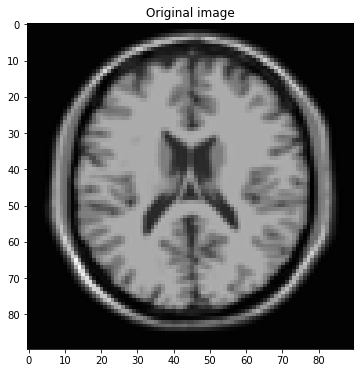

In [4]:
x_ = x.reshape((90,90), order = 'F')
fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(x_, cmap = 'gray')
ax.set_title('Original image')

Text(0.5, 1.0, 'Sinogram')

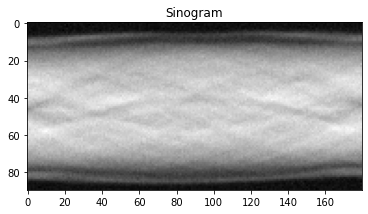

In [5]:
y_ = y.reshape((90,180), order = 'F')
fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(y_, cmap = 'gray')
ax.set_title('Sinogram')

# 2. Optimization problem

In [6]:
# downloading the gradient matrix 
G = loadmat('./data/G.mat')['G']

**2 -**
We have :
$$
\psi (u) = \sqrt{ 1 + u^2/\delta^2} \quad then \quad \psi'(u) = \frac{\frac{u}{\delta^2}}{\sqrt{ 1 + u^2/\delta^2}} : 
$$
So we have :
$$
 \quad \nabla f(x) = H^T (Hx - y) + \lambda \sum_{n=1}^{2N} \psi'([Gx]^{(n)})  G^{(n)} = H^T (Hx - y) + \lambda G^T( \psi'([Gx]^{(n)}) )_{1\leq n \leq 2N}
$$


In [7]:
# Computing the gradient in a point x
delta , lambd = 0.02, 0.13

def derivative_of_psi(u):
        return (u/(delta**2))* (1 / np.sqrt( 1 + (u/delta)**2))
    
    
def gradient(x):
    return H.T@(H@x -y) + lambd * G.T @ derivative_of_psi( G @ x )

**3-** 
$$
\nabla^2 f(x) = H^{T}H + \lambda G^{T}diag(( \psi''([Gx]^{(n)}) )_{1\leq n \leq 2N})G
$$
then we have:
$$
\lVert \nabla^2 f(x) \rVert \leq \lVert H^{T}H \rVert + \lambda\lVert G^{T}diag(( \psi''([Gx]^{(n)}) )_{1\leq n \leq 2N})G\rVert
\leq \lVert H^{T}H \rVert + \frac{\lambda}{\delta^2}\lVert G^{T}G \rVert \leq \rVert H \rVert ^2 + \frac{\lambda}{\delta^2} \lVert G \lVert ^2
$$
denote $$ L = \rVert H \rVert ^2 + \frac{\lambda}{\delta^2} \lVert G \lVert ^2 $$
which means that $ \nabla f $  is L-lipschitz.

In [8]:
# Computing the constant L:
H_norm = svds(H , k = 1 , which = 'LM')[1][0]
G_norm = svds(G , k = 1 , which = 'LM')[1][0]

L = H_norm**2 + (lambd/delta**2) * G_norm**2
print(L)

18092.77327686479


In [9]:
def psi(u):
    return np.sqrt( 1 + (u/delta)**2)

def f(x) : 
    return 0.5 * (np.linalg.norm(H @ x - y))**2 + lambd * np.sum(psi(G @ x))

# 3. Optimization algorithms

### 3.1 Gradient descent algorithm

In [10]:
# Convergene creteria 
N = G.shape[1]
epsilon = np.sqrt(N)*1e-4

In [129]:
# Initialization step
x0 = np.zeros(N)

# Implementing gredient descent algorithm

def Gradient_Descent(lr = 2/L, nb_iter = 1000, eps = epsilon):
    
    start = time.time()
    f_history = [f(x0)]
    x_history = [x0]
    times = [time.time()-start]
    
    x_n = x0.copy()
    n = 0
    convergence = False
    print('############# running Gradient_Descent ##############')
    while n < nb_iter and not convergence:
        
        x_n = x_n - lr * gradient(x_n)
        convergence = np.linalg.norm(gradient(x_n)) < eps
        n += 1 
        
        f_history.append(f(x_n))
        times.append(time.time()-start)
        x_history.append(x_n)
        
        if n % (nb_iter // 10) == 0:
            print(f'still progressing {n} -th iteration .....')
        
    return x_history, f_history, times

### 3.2 MM quadratic algorithm

According to what we saw at the course, a quadratic majorant is giving by the formula: 
$$
\forall x,y : h(x,y) = f(y) + <\nabla f(y) | x - y > + \frac{1}{2} < x-y | A(x - y)>
$$
where 
$$
A(x) = H^{T}H + \lambda G^{T}diag(( w([Gx]^{(n)}) ))G \quad ; \quad w(x) = \frac{\psi ' (x)}{x}
$$

In [144]:
H_ = H.T @ H # because we need to recompute it many times and it makes computation heavy

def w(x):
    return (1/(delta**2))* (1 / np.sqrt( 1 + (x/delta)**2))

def A(x):
    
    diag = diags(w(G @ x)).tocsc()
    
    def op(u): 
        return H_ @ u + lambd * (G.T @ diag @ G) @ u
    return LinearOperator( (N, N), matvec = op, rmatvec = op)

# Implementing MM algorithm

def MM_algorithm(lr = 2/L, nb_iter = 100, eps = epsilon):
    
    start = time.time()
    f_history = [f(x0)]
    x_history = [x0]
    times = [time.time()-start]
    
    x_n = x0.copy()
    n = 0
    
    convergence = False
    print('############# running MM_algorithm ##############')
    while n < nb_iter and not convergence:    
        x_n = x_n - lr * bicg(A(x_n), gradient(x_n))[0]
        convergence = np.linalg.norm(gradient(x_n)) < eps
        n += 1 
        
        f_history.append(f(x_n))
        times.append(time.time()-start)
        x_history.append(x_n)
        if n % (nb_iter // 10) == 0:
            print(f'still progressing {n} -th iteration .....')
    return x_history, f_history, times

### 3.3 3MG algorithm

In [117]:
def MMMG_algorithm(lr = 2/L, nb_iter = 1000, eps = epsilon):
    
    start = time.time()
    f_history = [f(x0)]
    x_history = [x0]
    times = [time.time()-start]
    
    previous_x = x0.copy()
    current_x = x0.copy()
    D = - gradient(current_x)[:,None]
    n = 0
    convergence = False
    print('############# running MMMG_algorithm ##############')
    while n < nb_iter and not convergence: 
        
        previous_x = current_x.copy()
        grad = gradient(previous_x)
        
        HD = H @ D # as suggested in the question
        GD = G @ D 
        
        help_matrix = (HD).T @ HD + lambd * (GD).T @ diags(w(G @ current_x)).tocsc() @ GD
        u = -pinv(help_matrix) @ D.T @ grad
        
        current_x = current_x + D @ u
        
        convergence = np.linalg.norm(gradient(current_x)) < eps

        D = - np.vstack((grad, current_x - previous_x)).T
        previous_x = current_x.copy()
        n+=1
        
        f_history.append(f(current_x))
        times.append(time.time()-start)
        x_history.append(current_x)
        
        if n % (nb_iter // 10) == 0:
            print(f'still progressing {n} -th iteration .....')
    return x_history, f_history, times

### 3.4 Block-coordinate MM quadratic algorithm

In [118]:
def cut_matrix(X, j, Nj):
    if len(X.shape) == 2:
        return X[:,Nj * (j - 1) : Nj*j]
    elif len(X.shape) == 1:
        return X[Nj * (j - 1) : Nj*j]

def A_j(x, j, Nj):
    
    G_j = cut_matrix(G, j, Nj)
    H_j = cut_matrix(H, j, Nj)
    
    H_j_ = H_j.T @ H_j
    
    diag = diags(w(G_j @ x)).tocsc()
    
    def op(u) :
        return H_j_ @ u + lambd * (G_j.T @ diag @ G_j) @ u

    return LinearOperator((Nj,Nj), matvec= op, rmatvec= op)

# Implementing Block_coordinate 
def Block_coordinate_MM_algorithm(k = 30, lr = 2/L, nb_iter = 1000, eps = epsilon):
    
    start = time.time()
    f_history = [f(x0)]
    x_history = [x0]
    times = [time.time()-start]
    
    Nj = N//k 
    
    times = [time.time() - start]
    x_n = x0.copy()
    n = 0
    convergence = False
    print('############# running Block_coordinate_MM_algorithm ##############')
    while n < nb_iter and not convergence: 
        
        j = n%k + 1 
        x_j = cut_matrix(x_n, j, Nj)
        grad_j = cut_matrix(gradient(x_n), j, Nj)
        x_n[Nj * (j - 1) : Nj*j] -= lr * bicg(A_j(x_j, j, Nj), grad_j)[0]
        convergence = np.linalg.norm(gradient(x_n)) < eps
        n += 1
        
        f_history.append(f(x_n))
        x_history.append(x_n)
        times.append(time.time()-start)
        
        if n % (nb_iter // 10) == 0:
            print(f'still progressing {n} -th iteration .....')
            
    return x_history, f_history, times

### 3.5 Parallel MM quadratic algorithm

**1-**

Let $x^{(1)}, ..., x^{(P)}$ and $y^{(1)}, ..., y^{(P)} $ and  $w^{(1)},....,w^{(P)}>0$ s.t $w^{(1)} + ... + w^{(P)} = 1$ and let g be a convex function. By Jensen's inequality, We have : \
\begin{equation}
    g(\sum_{p=1}^{P}y^{(p)}x^{(p)})= g(\sum_{p=1}^{P}\frac{w^{(p)}}{w^{(p)}}y^{(p)}x^{(p)}) \leq \sum_{p=1}^{P}w^{(p)}g(\frac{y^{(p)}}{w^{(p)}}x^{(p)})
\end{equation}

Taking $g: x \rightarrow x^2$ and $w^{(i)} = \frac{|H^{(m,i)}|}{\sum_{j=1}^{N}|H^{(m,j)}|}$ (we have $w^1 + ... + w^N = 1$ and $w^1,....,w^N>0$), so:
\begin{equation}
    [Hx]^m = \sum_{i=1}^{N}H^{(m,i)}x^i = \sum_{i=1}^{N}H^{(m,i)}x^i\frac{w^{(i)}}{w^{(i)}}
\end{equation}
And by Jensen's inequality we have:

\begin{equation}
    g([Hx]^m)  \leq \sum_{i=1}^{N}w_i\frac{(H^{(m,i)})^2}{w_i^2}x_i^2 \leq \sum_{i=1}^{N}\frac{(H^{(m,i)})^2}{w_i}x_i^2
\end{equation}

\begin{equation}
    ([Hx]^m)^2  \leq \sum_{i=1}^{N}\frac{(H^{(m,i)})^2}{w_i}x_i^2
\end{equation}

Since  $x^TH^THx = \sum_{m=1}^{M}([Hx]^m)^2 $:

\begin{equation}
 x^TH^THx = \sum_{m=1}^{M} ([Hx]^m)^2  \leq \sum_{m=1}^{M}\sum_{i=1}^{N}\frac{(H^{(m,i)})^2}{w_i}x_i^2
\end{equation}


\begin{equation}
      \leq \sum_{m=1}^{M}\sum_{i=1}^{N}(H^{(m,i)})^{2}x_i^2\frac{\sum_{j=1}^{N}|H^{(m,j)}|}{|H^{(m,i)}|}
\end{equation}

\begin{equation}
      \leq \sum_{m=1}^{M}\sum_{i=1}^{N}|H^{(m,i)}|x_i^2\sum_{j=1}^{N}|H^{(m,j)}|
\end{equation}

\begin{equation}
      \leq \sum_{m=1}^{M}\sum_{i=1}^{N}|\mathcal{H}^{(m,i)}|x_i^2
\end{equation}


Furthermore, let : $g_i: u \rightarrow w([Gx]^{(i)})u^2$ and $w^i = \frac{|G^{(n,i}|}{\sum_{j=1}^{N}G^{(n,i)}}$ (then $w^1 + ... + w^N = 1$ and $w^1,....,w^N>0$) we have :
\begin{equation}
    g_i([Gx]^n) = g_i(\sum_{p=1}^{N}G^{(n,p)}x^p\frac{w^{(p)}}{w^{(p)}})  \leq \sum_{p=1}^{N}\frac{(G^{(n,p)})^2}{w_p}w([Gx]^{(i)})x_p^2
\end{equation}
\begin{equation}
    g_i([Gx]^n)  \leq \sum_{p=1}^{N}|\mathcal{G}^{(n)}_p|w([Gx]^{(i)})x_p^2
\end{equation}
Hence
\begin{equation}
    x^TG^Tdiag(w([Gx]))Gx  = \sum_{n=1}^{2N} g_n([Gx]^n) \leq \sum_{n=1}^{2N}w([Gx]^{(n)})\sum_{p=1}^{N}|\mathcal{G}^{(n)}_p|x_p^2
\end{equation}
\
where $w([Gx]^{(i)}) = \frac{\dot{\psi}([Gx]^{(i)})}{[Gx]^{(i)}} = \frac{1}{\delta^2}\frac{1}{\psi([Gx]^{(i)})}$ \
By adding both inequalities we have:
\begin{equation}
x^TH^THx + \lambda x^TG^Tdiag(w([Gx]))Gx \leq \sum_{m=1}^{M}\sum_{i=1}^{N}|\mathcal{H}^{(m,i)}|x_i^2 + \frac{\lambda}{\delta^2} \sum_{n=1}^{2N}\frac{1}{\psi([Gx]^{(n)})}\sum_{p=1}^{N}|\mathcal{G}^{(n)}_p|x_p^2
\end{equation}

which is equivalent to $A(x) \preceq B(x)$  

In [119]:
# Implementing parallel MM quadratic algorithm
def Parallel_MM_algorithm(lr = 2/L, nb_iter = 1000, eps = epsilon):
    
    start = time.time()
    f_history = [f(x0)]
    x_history = [x0]
    times = [time.time()-start]
    
    H_sum, G_sum = diags(np.abs(H).toarray().sum(axis=1)).tocsc(), diags(np.abs(G).toarray().sum(axis=1)).tocsc()
    H_math, G_math = H_sum @ np.abs(H), G_sum @ np.abs(G)

    x_n = x0
    n = 0
    convergence = False
    print('############# running Parallel_MM_algorithm ##############')
    while n < nb_iter and not convergence: 
        grad = gradient(x_n)
        x_n = x_n - lr * (1/np.array(H_math.sum(axis=0) + lambd * G_math.T @ w(G@x_n)).flatten()) * grad 
        convergence = np.linalg.norm(gradient(x_n)) < eps
        n += 1
        
        f_history.append(f(x_n))
        x_history.append(x_n)
        times.append(time.time()-start)
        
        if n % (nb_iter // 10) == 0:
            print(f'still progressing {n} -th iteration .....')
        
    return x_history, f_history, times

### 3.6 Comparison of the methods

**1-** I changed the implementation of the algorithm to keep track of the evolution of the criterion f.

In [151]:
# 2 - 
# algorithms = [Parallel_MM_algorithm, Block_coordinate_MM_algorithm, MMMG_algorithm, MM_algorithm, Gradient_Descent()]
x_history_gd, f_history_gd, times_gd = Gradient_Descent()
x_history_mm, f_history_mm, times_mm = MM_algorithm(lr = 1)
x_history_mmg, f_history_mmg, times_mmg = MMMG_algorithm(lr = 1)
x_history_bcmm, f_history_bcmm, times_bcmm = Block_coordinate_MM_algorithm(lr =1)
x_history_pmm, f_history_pmm, times_pmm = Parallel_MM_algorithm(lr = 1)

x_histories = [ x_history_gd, x_history_mm, x_history_mmg, x_history_bcmm, x_history_pmm ]
f_histories = [ f_history_gd, f_history_mm, f_history_mmg, f_history_bcmm, f_history_pmm ]
times = [ times_gd, times_mm, times_mmg, times_bcmm, times_pmm ]

############# running Gradient_Descent ##############
still progressing 100 -th iteration .....
still progressing 200 -th iteration .....
still progressing 300 -th iteration .....
still progressing 400 -th iteration .....
still progressing 500 -th iteration .....
still progressing 600 -th iteration .....
still progressing 700 -th iteration .....
still progressing 800 -th iteration .....
still progressing 900 -th iteration .....
still progressing 1000 -th iteration .....
############# running MM_algorithm ##############
still progressing 10 -th iteration .....
still progressing 20 -th iteration .....
still progressing 30 -th iteration .....
still progressing 40 -th iteration .....
still progressing 50 -th iteration .....
still progressing 60 -th iteration .....
############# running MMMG_algorithm ##############
still progressing 100 -th iteration .....
still progressing 200 -th iteration .....
still progressing 300 -th iteration .....
still progressing 400 -th iteration .....
still pro

The required time for algorithm Gradient_Descent to be executed is : 27.48004722595215
The required time for algorithm MM_algorithm to be executed is : 392.22633266448975
The required time for algorithm MMMG_algorithm to be executed is : 24.07999849319458
The required time for algorithm Block_coordinate_MM_algorithm to be executed is : 82.62800574302673
The required time for algorithm Parallel_MM_algorithm to be executed is : 37.184009075164795


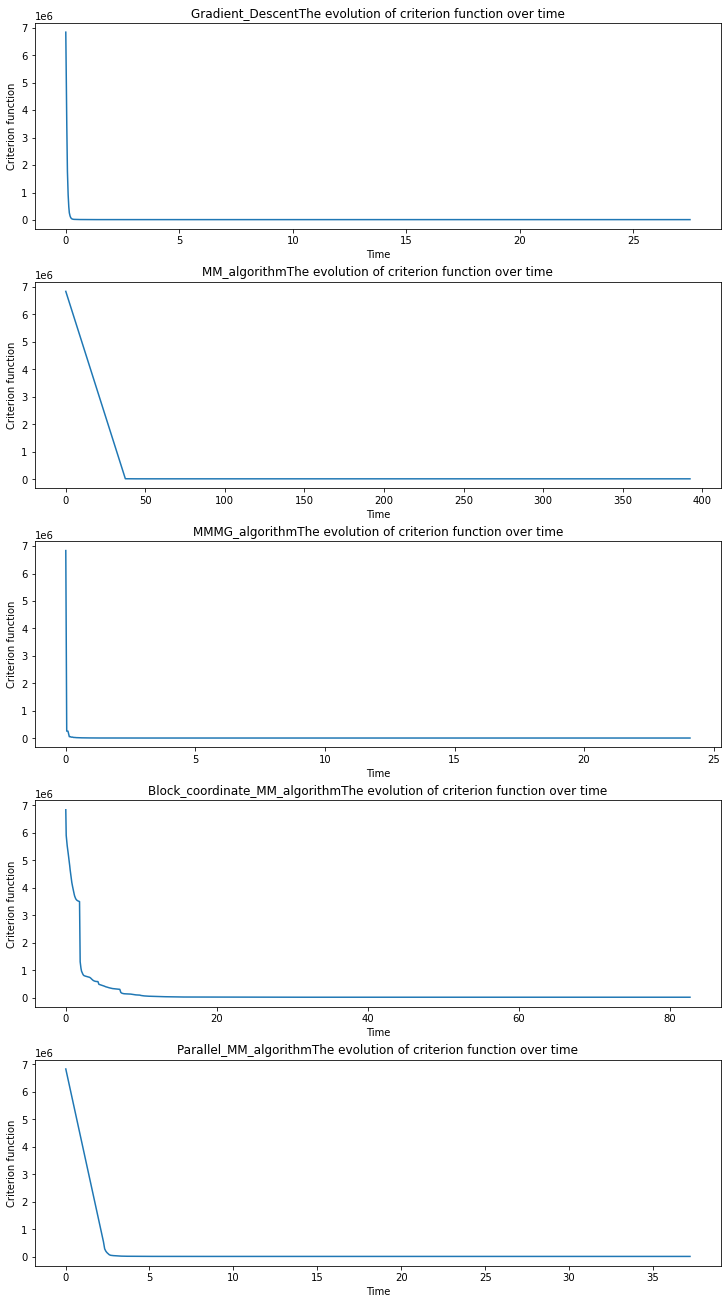

In [154]:
# Changing algorithms implementation to keep track of the criterion and the execution time 
algorithms = ['Gradient_Descent', 'MM_algorithm', 'MMMG_algorithm', 'Block_coordinate_MM_algorithm', 'Parallel_MM_algorithm']
fig,axes = plt.subplots(5, 1, figsize= (10,18), constrained_layout=True)
for i in range(5):
    print(f'The required time for algorithm {algorithms[i]} to be executed is : {times[i][-1] - times[i][0]}')
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Criterion function")
    axes[i].set_title(f"{algorithms[i]}The evolution of criterion function over time")
    axes[i].plot(times[i], f_histories[i])

In [165]:
# 3 -
def snr(x_estimated):
    return 10*np.log10((np.linalg.norm(x)/np.linalg.norm(x - x_estimated))**2)

# Since the fastest method is 3MG_algorithm let's use it, but we need to define a new function that takes as args also delta and lambda

def MMMG_algorithm(delta, lambd, lr = 1, nb_iter = 600, eps = epsilon):
    
    start = time.time()
#     x_history = [x0]
#     f_history = [f(x0)]
#     times = [time.time()-start]
    
    previous_x = x0.copy()
    current_x = x0.copy()
    
    D = - gradient(current_x)[:,None]
    
    n = 0
    convergence = False
    while n < nb_iter and not convergence:

        previous_x = current_x.copy()
        grad = gradient(previous_x)
        HD = H @ D 
        GD = G @ D 
        help_matrix = (HD).T @ HD + (lambd/(delta**2)) * (GD).T @ diags(1 / psi(G @ current_x)).tocsc() @ GD
        u = -pinv(help_matrix) @ D.T @ grad
        current_x = current_x + D @ u
        
        convergence = np.linalg.norm(gradient(current_x)) < eps
        
#         positions.append(current_x)
#         f_positions.append(f(current_x))
#         times.append(time.time() - start)
        
        
        D = - np.vstack((grad, current_x - previous_x)).T
        previous_x = current_x.copy()
    print(time.time() - start)
    return current_x

In [166]:
from tqdm import tqdm

lambdas = np.linspace(0.1, 1, 4)
deltas = np.linspace(0.01, 0.1, 4)
history = {}
for lambd in tqdm(lambdas):
    for delta in tqdm(deltas):
        history[(lambd, delta)] = snr(MMMG_algorithm(delta = delta, lambd = lambd))

 25%|█████████████████████                                                               | 1/4 [00:17<00:51, 17.20s/it]

17.20101022720337



 50%|██████████████████████████████████████████                                          | 2/4 [00:48<00:50, 25.21s/it]

30.810012578964233



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [02:06<00:49, 49.31s/it]

77.99098181724548



 25%|████████████████████▊                                                              | 1/4 [03:38<10:56, 218.72s/it]

92.59604740142822



 25%|████████████████████▊                                                              | 1/4 [03:33<10:40, 213.46s/it]

213.4559988975525



 50%|██████████████████████████████████████████                                          | 2/4 [03:53<03:19, 99.56s/it]

19.828044414520264



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [04:32<01:11, 71.84s/it]

38.8419988155365



 50%|█████████████████████████████████████████▌                                         | 2/4 [08:49<09:05, 272.99s/it]

38.83262801170349



 25%|████████████████████▊                                                              | 1/4 [04:24<13:12, 264.27s/it]

264.27341413497925



 50%|█████████████████████████████████████████▌                                         | 2/4 [04:38<03:54, 117.12s/it]

14.108503580093384



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [04:53<01:10, 70.70s/it]

15.446048498153687



 75%|██████████████████████████████████████████████████████████████▎                    | 3/4 [14:25<05:01, 301.71s/it]

42.020923137664795



 25%|████████████████████▊                                                              | 1/4 [04:13<12:41, 253.74s/it]

253.7420952320099



 50%|█████████████████████████████████████████▌                                         | 2/4 [04:23<03:40, 110.22s/it]

9.746999025344849



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [04:35<01:05, 65.54s/it]

12.38199782371521



100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [19:23<00:00, 290.82s/it]

21.82499933242798


In [167]:
print(min(history, key = lambda x:history[x]))

(1.0, 0.01)


**Best parameters found are: $\beta = 1.0$ and $\delta = 0.01$**

In [169]:
# As a final step let's splot the recovered image using these parameters:
reconstructed_image = MMMG_algorithm(delta = 0.01, lambd = 1)

43.30702257156372


Text(0.5, 1.0, 'Recovred image')

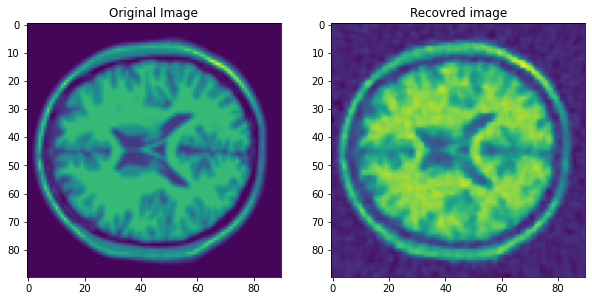

In [171]:
fig, axes = plt.subplots(1, 2 , figsize=(10,10))
axes[0].imshow(x.reshape(90,90))
axes[0].set_title("Original Image")
axes[1].imshow(reconstructed_image.reshape(90,90))
axes[1].set_title('Recovred image')